**ARECANUT DISEASE PREDICTION**

**IMPORT THE IMPORTANT PACKAGES**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tqdm import tqdm
import cv2

import imutils

In [2]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


## Downloading The Dataset

In [4]:

training="LumpySkin_Dataset/train"
testing="LumpySkin_Dataset/test"

# Image Preprocessing

In [6]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = "LumpySkin_Dataset/train"
	testing = "LumpySkin_Dataset/test"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'LumpySkin_Dataset/train'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = 'LumpySkin_Dataset/test'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

## Create a dataset

In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "LumpySkin_Dataset/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1024 files belonging to 2 classes.
Using 820 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "LumpySkin_Dataset/test",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 2 classes.
Using 88 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Lumpy_Skin', 'Normal_Skin']


## Visualize the data

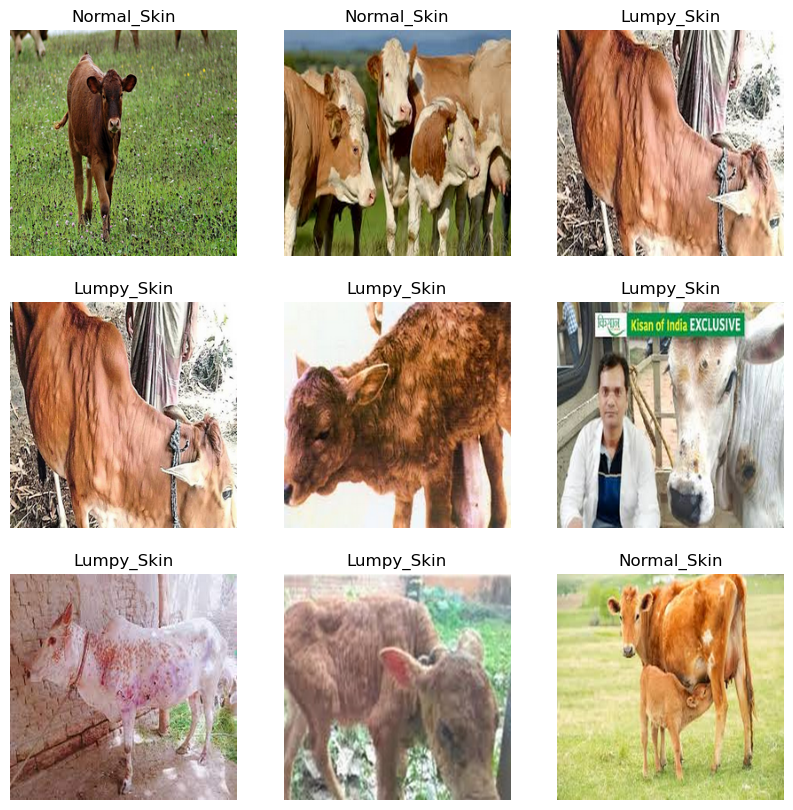

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9725491


## Create the model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [18]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model summary

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.6881 - loss: 1.0431 - val_accuracy: 0.6250 - val_loss: 0.6237
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.6907 - loss: 0.5252 - val_accuracy: 0.7500 - val_loss: 0.4219
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8049 - loss: 0.4061 - val_accuracy: 0.6932 - val_loss: 0.4035
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.8183 - loss: 0.3910 - val_accuracy: 0.7500 - val_loss: 0.3823
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8465 - loss: 0.3212 - val_accuracy: 0.9318 - val_loss: 0.3664
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.8878 - loss: 0.3222 - val_accuracy: 0.8977 - val_loss: 0.3045
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9279 - loss: 0.2224 - val_accuracy: 0.9773 - val_loss: 0.1623
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.9666 - loss: 0.1306 - val_accuracy: 0.

## Visualize training results

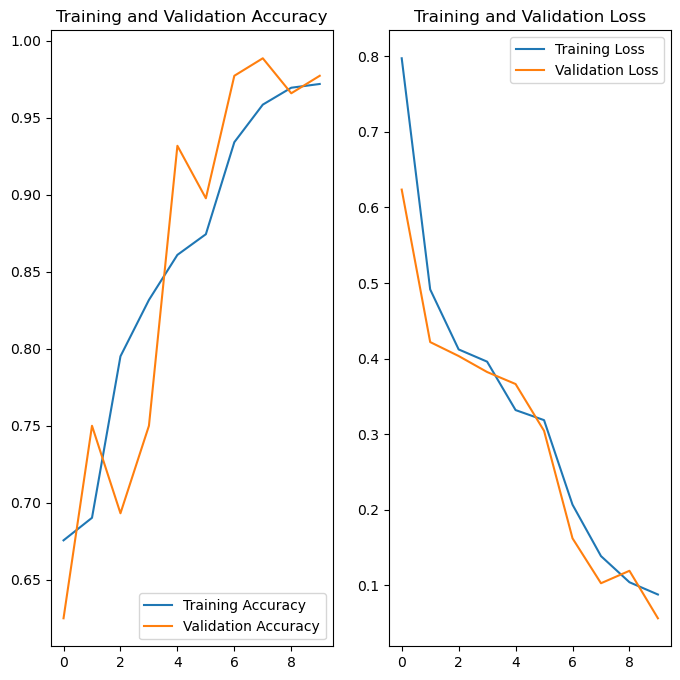

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

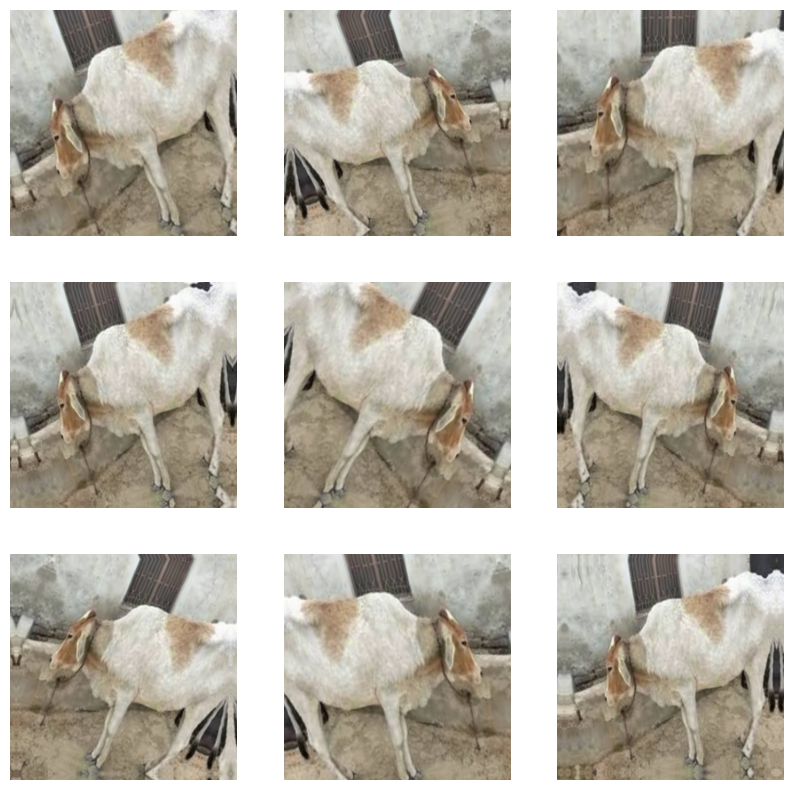

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [25]:
model.compile(optimizer='adam',
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=32
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.5907 - loss: 1.5006 - val_accuracy: 0.6250 - val_loss: 0.6628
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.7125 - loss: 0.6061 - val_accuracy: 0.6250 - val_loss: 0.5388
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.6991 - loss: 0.5299 - val_accuracy: 0.8182 - val_loss: 0.4326
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.7737 - loss: 0.4731 - val_accuracy: 0.8523 - val_loss: 0.3527
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8352 - loss: 0.3768 - val_accuracy: 0.8977 - val_loss: 0.2539
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.8363 - loss: 0.4011 - val_accuracy: 0.8750 - val_loss: 0.2748
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.8630 - loss: 0.3414 - val_accuracy: 0.8864 - val_loss: 0.2797
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.8450 - loss: 0.3829 - val_accuracy: 0.

## Visualize training results

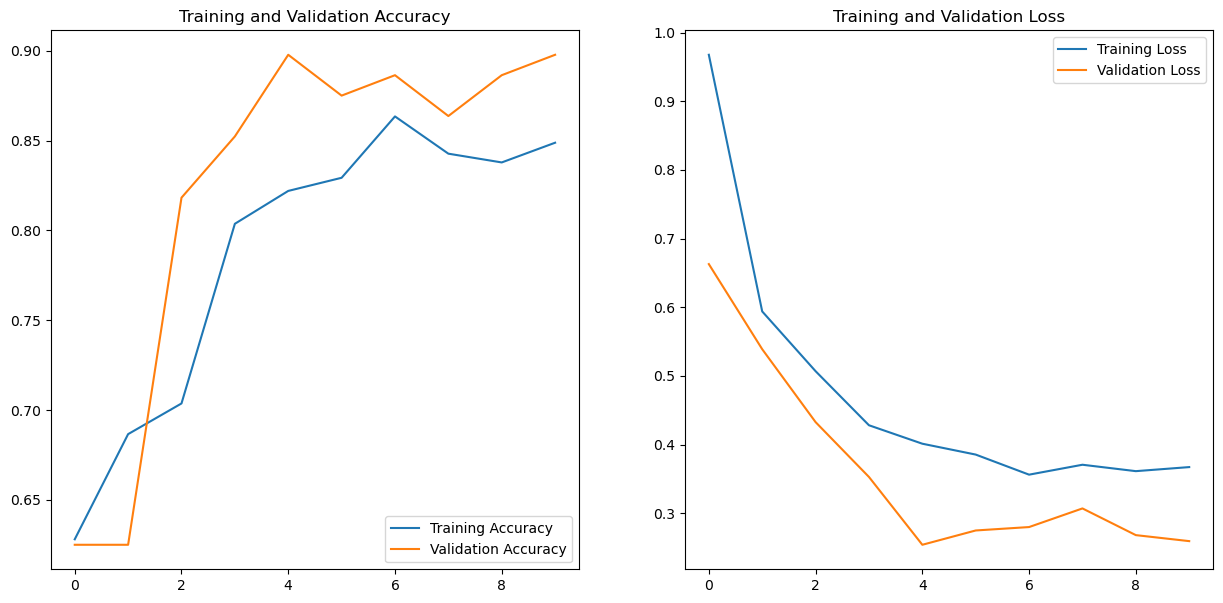

<Figure size 640x480 with 0 Axes>

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("Accuracy.png")

## Predict on new data

In [29]:
import numpy as np
from keras.preprocessing import image
#test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/yellowleafdisease/y1.jpg', target_size = (256, 256))
test_image = image.load_img('K:/PROJECTS 2024/LUMPYSKIN FINAL/LumpySkin_Dataset/test/Normal_Skin/Normal_Skin_301.png', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
 Normal_Skin with a 99.87 


In [31]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('K:/PROJECTS 2024/LUMPYSKIN FINAL/LumpySkin_Dataset/test/Normal_Skin/Normal_Skin_204.png', target_size = (256, 256))
#test_image = image.load_img('C:/Users/Dell/Arecanut_dataset/test/Stem_bleeding/s15.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 Normal_Skin with a 94.48 


In [32]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('K:/PROJECTS 2024/LUMPYSKIN FINAL/LumpySkin_Dataset/test/Normal_Skin/Normal_Skin_18.png', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 Normal_Skin with a 59.64 


In [33]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('K:/PROJECTS 2024/LUMPYSKIN FINAL/LumpySkin_Dataset/test/Lumpy_Skin/Lumpy_Skin_12.png', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 Lumpy_Skin with a 56.40 


In [35]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('K:/PROJECTS 2024/LUMPYSKIN FINAL/LumpySkin_Dataset/test/Lumpy_Skin/Lumpy_Skin_48.png', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_ds.class_indices
resul = " {} with a {:.2f} ".format(class_names[np.argmax(result)],
                                         100 * np.max(result))
print(resul)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 Lumpy_Skin with a 64.90 


In [46]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import pickle

In [48]:
!pip install pickle

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [52]:
from keras.models import load_model

In [55]:
from keras.models import load_model

model.save('cnn.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('cnn_model.h5')

TypeError: cannot pickle 'module' object

In [61]:
model.save('LumpySkin_Dataset/cnn_models.h5')

TypeError: cannot pickle 'module' object

In [60]:
model.save('LumpySkin_Dataset/cnn_model.keras')